# 這份檔案會講解以下幾個部分:

* X-ray image normalization
* 如何把 mask image 轉為 bounding box
* 如何把資料集轉換為 COCO format
* 如何將資料存為 .jpg & .json

---

# Rename files & Save .csv as UTF-8 encoding format

1. 上傳資料前先將資料夾名稱換成英文:

* normal -> normal
* 心臟肥大 -> cardiac_hypertrophy
* 主動脈硬鈣化 -> aortic_atherosclerosis_calcification
* 主動脈彎曲 -> aortic_curvature
* 肺尖肋膜增厚 -> intercostal_pleural_thickening
* 肺野浸潤增加 -> lung_field_infiltration
* 胸椎退化性關節病變 -> degenerative_joint_disease_of_the_thoracic_spine
* 脊椎側彎 -> scoliosis

2. 另外，要先在自己的電腦用記事本打開 csv 檔，並另存為 utf-8 編碼再上傳，不然打開會出現亂碼！

---

# Check data & images

In [1]:
# import libraries

# basic
import warnings
warnings.filterwarnings('ignore')

import os
import random
import pydicom
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

# visualization
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

# object detection
import json
from skimage.measure import label as sk_label
from skimage.measure import regionprops as sk_regions
from torchvision.transforms.v2 import functional as F

In [2]:
class config:
    
    root = "/kaggle/input/hwk05-data/hwk05_data" ## your own base root path
    seed = 42

In [3]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
seed_everything(config.seed)

In [4]:
# training dataframe
train_df = pd.read_csv("/kaggle/input/hwk05-data/hwk05_data/train/train.csv", encoding='big5')
train_df

ID category  Width  Height    Filename  \
0    TDR04_20180315_075734   normal   2328    2344  220_97.dcm   
1    TDR04_20180315_080518   normal   2472    2560  220_94.dcm   
2    TDR04_20180315_081322   normal   2312    2496  220_93.dcm   
3    TDR04_20180315_081746   normal   2448    2584  220_92.dcm   
4    TDR04_20180315_082113   normal   2144    2384  220_91.dcm   
..                     ...      ...    ...     ...         ...   
446  TDR02_20161209_161439     脊椎側彎   2376    2592  4440_5.dcm   
447  TDR04_20180224_084933     脊椎側彎   2248    2600  4440_0.dcm   
448  TDR04_20180226_082354     脊椎側彎   2488    2456    4440.dcm   
449  TDR01_20171106_095308     脊椎側彎   2320    2376   A0_29.dcm   
450  TDR01_20171108_100516     脊椎側彎   2280    2288   A0_28.dcm   

                    ImagePath                     MarkPath  
0    /normal/image/220_97.dcm  /normal/mark/220_97.dcm.jpg  
1    /normal/image/220_94.dcm  /normal/mark/220_94.dcm.jpg  
2    /normal/image/220_93.dcm  /normal/mark/220_93.dcm.jpg  
3    /normal/image/220_92.dcm  /normal/mark/220_92.dcm.jpg  
4    /normal/image/220_91.dcm  /normal/mark/220_91.dcm.jpg  
..                        ...                          ...  
446    /脊椎側彎/image/4440_5.dcm    /脊椎側彎/mark/4440_5.dcm.jpg  
447    /脊椎側彎/image/4440_0.dcm    /脊椎側彎/mark/4440_0.dcm.jpg  
448      /脊椎側彎/image/4440.dcm      /脊椎側彎/mark/4440.dcm.jpg  
449     /脊椎側彎/image/A0_29.dcm     /脊椎側彎/mark/A0_29.dcm.jpg  
450     /脊椎側彎/image/A0_28.dcm     /脊椎側彎/mark/A0_28.dcm.jpg  

[451 rows x 7 columns]

## 更改類別名稱為英文

In [5]:
# all classes
category = {
    "心臟肥大": "cardiac_hypertrophy",
    "主動脈硬鈣化": "aortic_atherosclerosis_calcification",
    "主動脈彎曲": "aortic_curvature",
    "肺尖肋膜增厚": "intercostal_pleural_thickening",
    "肺野浸潤增加": "lung_field_infiltration",
    "胸椎退化性關節病變": "degenerative_joint_disease_of_the_thoracic_spine",
    "脊椎側彎": "scoliosis",
    "normal": "normal"
}

In [6]:
# change category names to English
def change_to_eng_names(df):
    
    df["category"] = df["category"].apply(lambda x: category[x])
    df["ImagePath"] = df.apply(lambda df: "/".join([df["category"], "image", df["Filename"]]), axis=1)
    df["MarkPath"] = df.apply(lambda df: "/".join([df["category"], "mark", df["Filename"] + ".jpg"]), axis=1)

change_to_eng_names(train_df)
train_df

ID   category  Width  Height    Filename  \
0    TDR04_20180315_075734     normal   2328    2344  220_97.dcm   
1    TDR04_20180315_080518     normal   2472    2560  220_94.dcm   
2    TDR04_20180315_081322     normal   2312    2496  220_93.dcm   
3    TDR04_20180315_081746     normal   2448    2584  220_92.dcm   
4    TDR04_20180315_082113     normal   2144    2384  220_91.dcm   
..                     ...        ...    ...     ...         ...   
446  TDR02_20161209_161439  scoliosis   2376    2592  4440_5.dcm   
447  TDR04_20180224_084933  scoliosis   2248    2600  4440_0.dcm   
448  TDR04_20180226_082354  scoliosis   2488    2456    4440.dcm   
449  TDR01_20171106_095308  scoliosis   2320    2376   A0_29.dcm   
450  TDR01_20171108_100516  scoliosis   2280    2288   A0_28.dcm   

                      ImagePath                       MarkPath  
0       normal/image/220_97.dcm     normal/mark/220_97.dcm.jpg  
1       normal/image/220_94.dcm     normal/mark/220_94.dcm.jpg  
2       normal/image/220_93.dcm     normal/mark/220_93.dcm.jpg  
3       normal/image/220_92.dcm     normal/mark/220_92.dcm.jpg  
4       normal/image/220_91.dcm     normal/mark/220_91.dcm.jpg  
..                          ...                            ...  
446  scoliosis/image/4440_5.dcm  scoliosis/mark/4440_5.dcm.jpg  
447  scoliosis/image/4440_0.dcm  scoliosis/mark/4440_0.dcm.jpg  
448    scoliosis/image/4440.dcm    scoliosis/mark/4440.dcm.jpg  
449   scoliosis/image/A0_29.dcm   scoliosis/mark/A0_29.dcm.jpg  
450   scoliosis/image/A0_28.dcm   scoliosis/mark/A0_28.dcm.jpg  

[451 rows x 7 columns]

## 畫出8種類別的第一張 image & mask 位置

這裡如果類別是 normal，就自行生成一個 shape 和原始影像相同的 mask。

In [7]:
temp = train_df[train_df["category"].duplicated() == False]
temp

ID                                          category  \
0    TDR04_20180315_075734                                            normal   
80   TDR04_20180227_083423                                  aortic_curvature   
132  TDR01_20190313_090724              aortic_atherosclerosis_calcification   
203  TDR04_20180226_090403                               cardiac_hypertrophy   
236  TDR05_20151105_094209                    intercostal_pleural_thickening   
265  TDR04_20180227_083423                           lung_field_infiltration   
333  TDR04_20180227_085056  degenerative_joint_disease_of_the_thoracic_spine   
393  TDR01_20171109_083459                                         scoliosis   

     Width  Height    Filename  \
0     2328    2344  220_97.dcm   
80    2504    2536  220_14.dcm   
132   2392    2600   10_1d.dcm   
203   2008    2280    4440.dcm   
236   2296    2512  4440_4.dcm   
265   2504    2536   220_3.dcm   
333   2336    2360  220_15.dcm   
393   2232    2408   A0_26.dcm   

                                             ImagePath  \
0                              normal/image/220_97.dcm   
80                   aortic_curvature/image/220_14.dcm   
132  aortic_atherosclerosis_calcification/image/10_...   
203                 cardiac_hypertrophy/image/4440.dcm   
236    intercostal_pleural_thickening/image/4440_4.dcm   
265            lung_field_infiltration/image/220_3.dcm   
333  degenerative_joint_disease_of_the_thoracic_spi...   
393                          scoliosis/image/A0_26.dcm   

                                              MarkPath  
0                           normal/mark/220_97.dcm.jpg  
80                aortic_curvature/mark/220_14.dcm.jpg  
132  aortic_atherosclerosis_calcification/mark/10_1...  
203              cardiac_hypertrophy/mark/4440.dcm.jpg  
236  intercostal_pleural_thickening/mark/4440_4.dcm...  
265         lung_field_infiltration/mark/220_3.dcm.jpg  
333  degenerative_joint_disease_of_the_thoracic_spi...  
393                       scoliosis/mark/A0_26.dcm.jpg

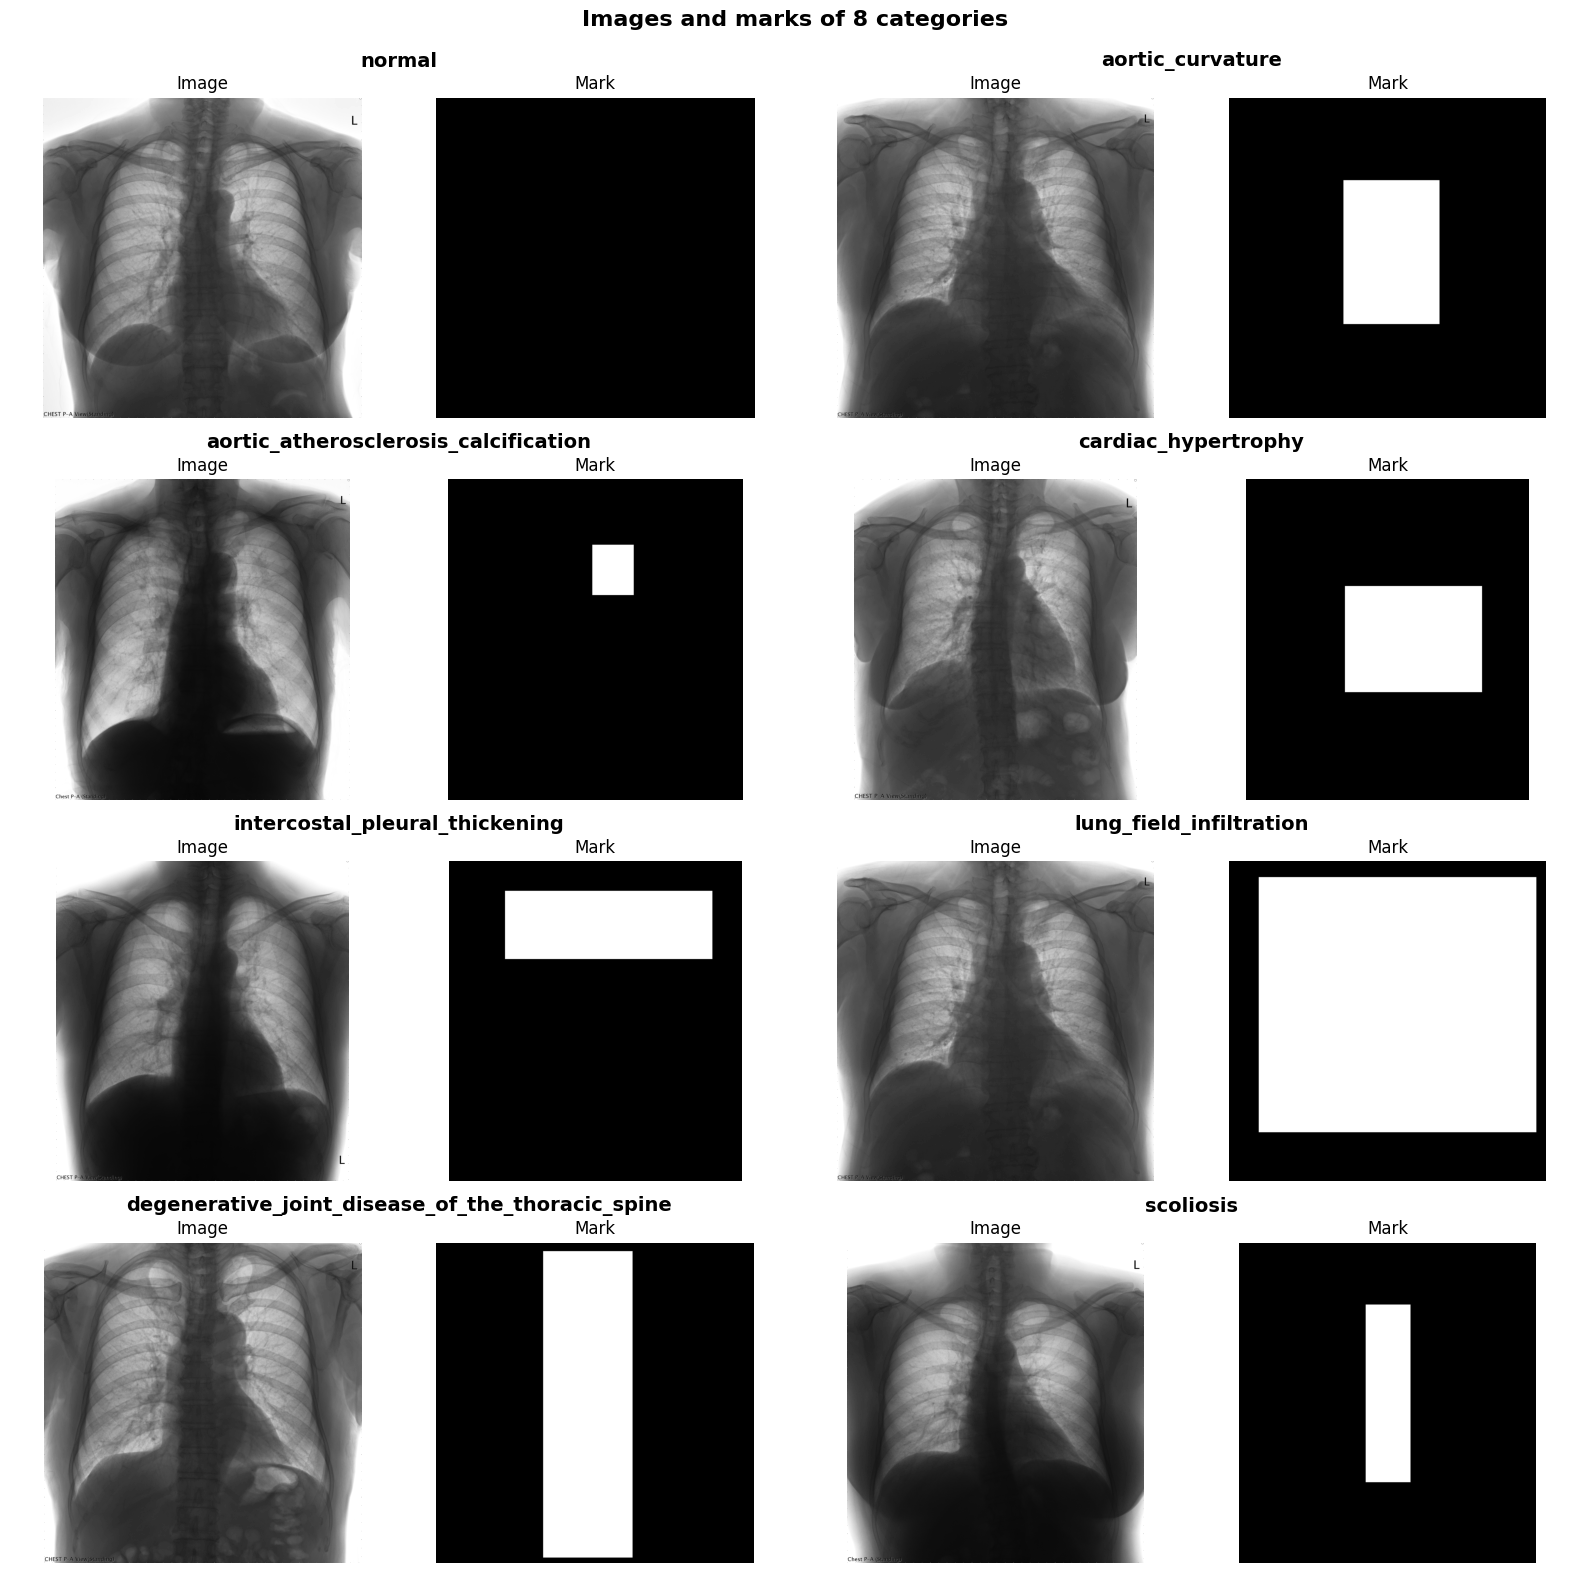

In [8]:
def plot_images_and_marks(df):
    
    temp = df[df["category"].duplicated() == False]
    
    rows, cols = 4, 2
    fig = plt.figure(figsize = (16, 16))
    grid = plt.GridSpec(rows, cols)
    
    for i in range(rows * cols):
        image = pydicom.dcmread(os.path.join(config.root, "train", temp.iloc[i, 5])).pixel_array
        if temp.iloc[i, 1] != "normal":
            mark = np.array(Image.open(os.path.join(config.root, "train", temp.iloc[i, 6])))
        else:
            mark = np.zeros((image.shape[0], image.shape[1]))
        
        categories = fig.add_subplot(grid[i])
        categories.set_title(f"{temp.iloc[i, 1]}\n", fontweight = 'semibold', size = 14)
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(image, cmap = "gray")
        ax.set_title("Image")
        ax.axis("off")
        
        ax = fig.add_subplot(gs[1], sharey = ax)
        ax.imshow(mark, cmap = "gray")
        ax.set_title("Mark")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("Images and marks of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()
      
plot_images_and_marks(train_df)

---

# X-ray image normalization

這部分需完成 **intensity log-transformation** 跟 **simplest color balance algorithm** ，目的是為了轉換影像型態及調整 L & R 字樣的亮度。  
以 ID 為 TDR02_20161209_161439 的病患為例，輸出轉換前及轉換後的 X-ray 影像：

In [9]:
def X_ray_normalization(dcm_file, vmin, vmax):
    
    img = pydicom.dcmread(dcm_file)
    origin = img.pixel_array
    
    # needed values
    WW = img.WindowWidth
    WC = img.WindowCenter
    BitsStored = img.BitsStored

    # Compute min and max intensity bounds
    imin = WC - (WW / 2)
    imax = WC + (WW / 2)
    # Clip pixel values based on imin and imax
    clipped = np.clip(origin, imin, imax)
    # Perform intensity log-transformation
    log_img = -np.log((1 + clipped) / (2 ** BitsStored))
    
    # simplest color balance algorithm
    # lower_bound = np.percentile(log_img, vmin)
    # upper_bound = np.percentile(log_img, vmax)
    normalize_img = (log_img - vmin) / (vmax - vmin)
    normalize_img = np.clip(normalize_img, 0, 1)

    
    return origin, log_img, normalize_img

<Figure size 1600x1600 with 0 Axes>

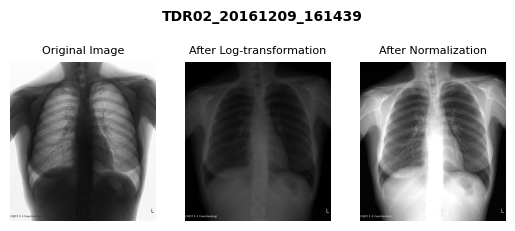

In [10]:
def plot_before_and_after(ID, df):
    
    patient_df = df[df["ID"] == ID]
    path = os.path.join(config.root, "train", patient_df.iloc[0, 5])
    origin, log_img, normalize_img = X_ray_normalization(path, vmin = 0, vmax = 2.5)
    
    plt.figure(figsize = (16, 16))
    fig, ax = plt.subplots(1, 3)
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    plt.subplots_adjust(wspace = None, hspace = None)
    
    ax[0].imshow(origin, cmap = "gray")
    ax[0].set_title("Original Image", size = 8)
    ax[1].imshow(log_img, cmap = "gray")
    ax[1].set_title("After Log-transformation", size = 8)
    ax[2].imshow(normalize_img, cmap = "gray")
    ax[2].set_title("After Normalization", size = 8)
          
    fig.suptitle(f"{ID}", fontweight = 'bold', size = 10, x = 0.52, y = 0.77)
    
plot_before_and_after(ID = "TDR02_20161209_161439", df = train_df)

---

# Mask image to bounding box

這部分將資料集中的 mask 轉換為丟入模型所需的 bounding box，並畫出8種類別的轉換後影像、轉換後影像及 bounding box，以及 mask 影像：

In [11]:
def mask_to_bbox(mark_path):
    img = np.array(Image.open(mark_path))

    mask = img != 0
    sk_mask = sk_label(mask, connectivity = 2)
    regions = sk_regions(sk_mask)
    bboxes = []
    for region in regions:
        if region.area < 3000 :
            continue
        bboxes.append(region.bbox)

    ymin, xmin, ymax, xmax = bboxes[0]
    
    return xmin, ymin, xmax, ymax

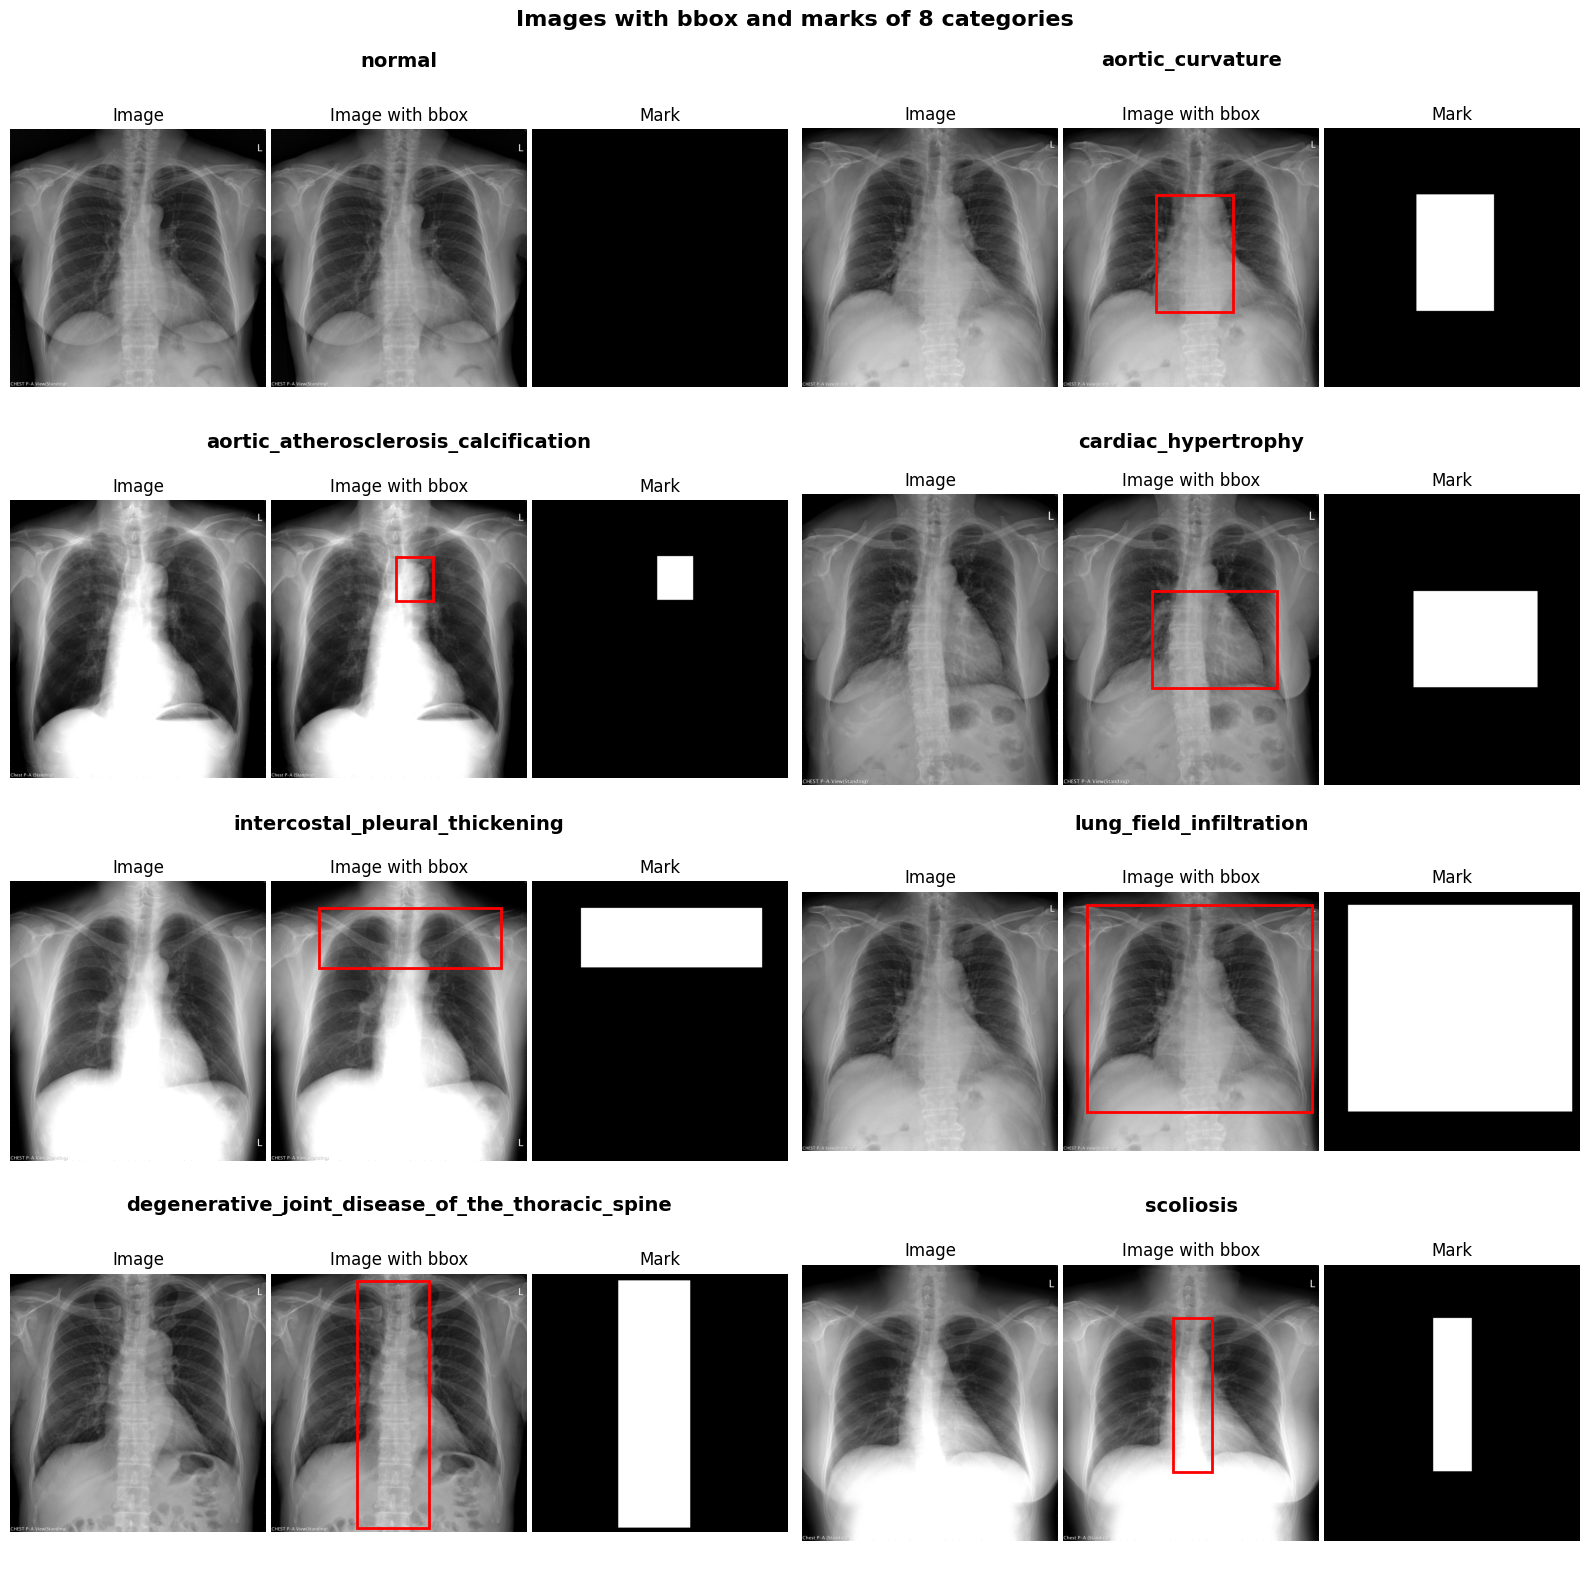

In [12]:
def plot_bbox_and_mark(df):
    
    temp = df[df["category"].duplicated() == False]
    
    rows, cols = 4, 2
    fig = plt.figure(figsize = (16, 16))
    grid = plt.GridSpec(rows, cols)
    
    for i in range(rows * cols):
        
        path = os.path.join(config.root, "train", temp.iloc[i, 5])
        mark_path = os.path.join(config.root, "train", temp.iloc[i, 6])
        
        _, _, after = X_ray_normalization(path, vmin = 0, vmax = 2.5)
        
        if temp.iloc[i, 1] != "normal":
            mark = np.array(Image.open(mark_path))
            xmin, ymin, xmax, ymax = mask_to_bbox(mark_path)
        else:
            mark = np.zeros((after.shape[0], after.shape[1]))
            xmin, ymin, xmax, ymax = 0, 0, 0, 0
        
        bbox = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth = 2, 
                                 edgecolor = "r", facecolor = 'none')
        
        categories = fig.add_subplot(grid[i])
        categories.set_title(f"{temp.iloc[i, 1]}\n", fontweight = 'semibold', size = 14)
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(after, cmap = "gray")
        ax.set_title("Image")
        ax.axis("off")
        
        ax = fig.add_subplot(gs[1], sharey = ax)
        ax.imshow(after, cmap = "gray")
        ax.add_patch(bbox)
        ax.set_title("Image with bbox")
        ax.axis("off")
        
        ax = fig.add_subplot(gs[2], sharey = ax)
        ax.imshow(mark, cmap = "gray")
        ax.set_title("Mark")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("Images with bbox and marks of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()
      
plot_bbox_and_mark(train_df)

接著將轉換出的 bounding box 寫入 training dataframe 中：

In [13]:
def write_bbox(df):
    
    all_xmin, all_ymin, all_xmax, all_ymax = [], [], [], []
    
    for i in range(df.shape[0]):
        
        if df.iloc[i, 1] != "normal":
            mark_path = os.path.join(config.root, "train", df.iloc[i, 6])
            xmin, ymin, xmax, ymax = mask_to_bbox(mark_path)
        else:
            xmin, ymin, xmax, ymax = 0, 0, 0, 0
        
        all_xmin.append(xmin)
        all_ymin.append(ymin)
        all_xmax.append(xmax)
        all_ymax.append(ymax)
        
    df["xmin"] = all_xmin
    df["ymin"] = all_ymin
    df["xmax"] = all_xmax
    df["ymax"] = all_ymax
    
write_bbox(train_df)
train_df

ID   category  Width  Height    Filename  \
0    TDR04_20180315_075734     normal   2328    2344  220_97.dcm   
1    TDR04_20180315_080518     normal   2472    2560  220_94.dcm   
2    TDR04_20180315_081322     normal   2312    2496  220_93.dcm   
3    TDR04_20180315_081746     normal   2448    2584  220_92.dcm   
4    TDR04_20180315_082113     normal   2144    2384  220_91.dcm   
..                     ...        ...    ...     ...         ...   
446  TDR02_20161209_161439  scoliosis   2376    2592  4440_5.dcm   
447  TDR04_20180224_084933  scoliosis   2248    2600  4440_0.dcm   
448  TDR04_20180226_082354  scoliosis   2488    2456    4440.dcm   
449  TDR01_20171106_095308  scoliosis   2320    2376   A0_29.dcm   
450  TDR01_20171108_100516  scoliosis   2280    2288   A0_28.dcm   

                      ImagePath                       MarkPath  xmin  ymin  \
0       normal/image/220_97.dcm     normal/mark/220_97.dcm.jpg     0     0   
1       normal/image/220_94.dcm     normal/mark/220_94.dcm.jpg     0     0   
2       normal/image/220_93.dcm     normal/mark/220_93.dcm.jpg     0     0   
3       normal/image/220_92.dcm     normal/mark/220_92.dcm.jpg     0     0   
4       normal/image/220_91.dcm     normal/mark/220_91.dcm.jpg     0     0   
..                          ...                            ...   ...   ...   
446  scoliosis/image/4440_5.dcm  scoliosis/mark/4440_5.dcm.jpg  1016   560   
447  scoliosis/image/4440_0.dcm  scoliosis/mark/4440_0.dcm.jpg   912   552   
448    scoliosis/image/4440.dcm    scoliosis/mark/4440.dcm.jpg  1016   464   
449   scoliosis/image/A0_29.dcm   scoliosis/mark/A0_29.dcm.jpg  1032   512   
450   scoliosis/image/A0_28.dcm   scoliosis/mark/A0_28.dcm.jpg   912   592   

     xmax  ymax  
0       0     0  
1       0     0  
2       0     0  
3       0     0  
4       0     0  
..    ...   ...  
446  1432  2328  
447  1408  2272  
448  1560  2184  
449  1384  2016  
450  1392  2120  

[451 rows x 11 columns]

---

# Write class id

因之後轉換資料格式所需，我們需要把疾病類別改寫為 `class_id`，也就是 0 ~ 7 的數字。

In [14]:
labels = list(train_df["category"].unique())
label2class = {l: c for c, l in enumerate(labels)}
label2class

{'normal': 0,
 'aortic_curvature': 1,
 'aortic_atherosclerosis_calcification': 2,
 'cardiac_hypertrophy': 3,
 'intercostal_pleural_thickening': 4,
 'lung_field_infiltration': 5,
 'degenerative_joint_disease_of_the_thoracic_spine': 6,
 'scoliosis': 7}

In [15]:
# write class_id
def write_class_id(df):
    class_id = []
    for i in range(df.shape[0]):
        class_id.append(label2class[df.iloc[i, 1]])
    df["class_id"] = class_id
    
write_class_id(train_df)
train_df

ID   category  Width  Height    Filename  \
0    TDR04_20180315_075734     normal   2328    2344  220_97.dcm   
1    TDR04_20180315_080518     normal   2472    2560  220_94.dcm   
2    TDR04_20180315_081322     normal   2312    2496  220_93.dcm   
3    TDR04_20180315_081746     normal   2448    2584  220_92.dcm   
4    TDR04_20180315_082113     normal   2144    2384  220_91.dcm   
..                     ...        ...    ...     ...         ...   
446  TDR02_20161209_161439  scoliosis   2376    2592  4440_5.dcm   
447  TDR04_20180224_084933  scoliosis   2248    2600  4440_0.dcm   
448  TDR04_20180226_082354  scoliosis   2488    2456    4440.dcm   
449  TDR01_20171106_095308  scoliosis   2320    2376   A0_29.dcm   
450  TDR01_20171108_100516  scoliosis   2280    2288   A0_28.dcm   

                      ImagePath                       MarkPath  xmin  ymin  \
0       normal/image/220_97.dcm     normal/mark/220_97.dcm.jpg     0     0   
1       normal/image/220_94.dcm     normal/mark/220_94.dcm.jpg     0     0   
2       normal/image/220_93.dcm     normal/mark/220_93.dcm.jpg     0     0   
3       normal/image/220_92.dcm     normal/mark/220_92.dcm.jpg     0     0   
4       normal/image/220_91.dcm     normal/mark/220_91.dcm.jpg     0     0   
..                          ...                            ...   ...   ...   
446  scoliosis/image/4440_5.dcm  scoliosis/mark/4440_5.dcm.jpg  1016   560   
447  scoliosis/image/4440_0.dcm  scoliosis/mark/4440_0.dcm.jpg   912   552   
448    scoliosis/image/4440.dcm    scoliosis/mark/4440.dcm.jpg  1016   464   
449   scoliosis/image/A0_29.dcm   scoliosis/mark/A0_29.dcm.jpg  1032   512   
450   scoliosis/image/A0_28.dcm   scoliosis/mark/A0_28.dcm.jpg   912   592   

     xmax  ymax  class_id  
0       0     0         0  
1       0     0         0  
2       0     0         0  
3       0     0         0  
4       0     0         0  
..    ...   ...       ...  
446  1432  2328         7  
447  1408  2272         7  
448  1560  2184         7  
449  1384  2016         7  
450  1392  2120         7  

[451 rows x 12 columns]

---

# Split training set and validation set

這裡要注意的是，由於一張影像可能包含許多類不同疾病 ( multi-label ) ，所以在切分 training set 跟 validation set 時不能用一般的 `train_test_split` ，否則會導致類別不平衡。此外，由於一名病人在 dataframe 中可能有多筆資料，所以分的時候記得要用 ID 去分！

首先把疾病類別改寫為 one-hot encoding 形式：

In [16]:
train_df.nunique()['ID'], train_df.shape[0]

(348, 451)

In [17]:
binarizer = MultiLabelBinarizer()
disease_id = []
for ID in train_df.ID.unique():
    diseases = []
    temp = train_df[train_df["ID"] == ID]
    diseases.extend(list(temp["class_id"]))
    disease_id.append(diseases)

one_hot = binarizer.fit_transform(disease_id)
one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [18]:
one_hot.shape

(348, 8)

In [19]:
train_ID, train_label, val_ID, val_label = iterative_train_test_split(np.expand_dims(train_df["ID"].unique(), axis = 1), one_hot, test_size = 0.2)

training = train_df[train_df["ID"].isin(train_ID.ravel())]
validation = train_df[train_df["ID"].isin(val_ID.ravel())]

---
# Dataset to COCO format
https://cocodataset.org/#format-data

大部分 object detection 模型要求丟入的資料格式為 Pascal VOC format 或 COCO format，這裡示範如何將資料轉換為 COCO format。

COCO dataset 包含五個部分，分別是：
* `info` : general information about the dataset
* `licenses` : license information for the images in the dataset
* `images` : a list of images in the dataset
* `annotations` : a list of annotations ( including bounding boxes ) that are present in all images in the dataset
* `categories` : a list of label categories

其中 `info` 和 `licenses` 並非必要，所以這裡我們只創建 `images`、`annotations` 和 `categories` 這三部分

In [20]:
categories = []
for l, c in label2class.items():
    if l == "normal":
        continue
    categories.append({"id": c, "name": l})

categories

[{'id': 1, 'name': 'aortic_curvature'},
 {'id': 2, 'name': 'aortic_atherosclerosis_calcification'},
 {'id': 3, 'name': 'cardiac_hypertrophy'},
 {'id': 4, 'name': 'intercostal_pleural_thickening'},
 {'id': 5, 'name': 'lung_field_infiltration'},
 {'id': 6, 'name': 'degenerative_joint_disease_of_the_thoracic_spine'},
 {'id': 7, 'name': 'scoliosis'}]

## Format:
A dictionary containing 3 key items below, an individual item consists of a list of dictionaries

https://www.v7labs.com/blog/coco-dataset-guide


#### **Images**
* **id**
* **file_name**
* **height and width**


#### **Annotations**
* **id**: annotation unique id
* **image_id**: The ID of image(id under **Images**) that this annotation belongs to.
* **category_id**: ID of the object's category.
* **bbox**: Bounding box **[x, y, width, height]**
* **segmentation**: Segmentation polygons for the object.
* **area**: Area of the object (used for filtering).
* **iscrowd**: Flag indicating if the annotation is for a crowd (e.g., a dense cluster of objects).

#### **Categories**


### Bounding boxes format
![info](https://global.discourse-cdn.com/flex015/uploads/hailo/optimized/1X/0e7075c37a45181b7387d3c5f414ecf3fc6a38eb_2_1035x633.png)

In [21]:
# change data to coco format
def coco_format(df, categories):
    coco_output = {
        "images" : [],
        "categories" : [],
        "annotations" : []
        }
 
    coco_output['categories'] = categories

    annotation_id = 0
    for image_id, img_name in enumerate(df.ID.unique()):
        image_df = df[df.ID == img_name]
        if len(image_df) == 1:
            image_dict = {
                "file_name" : list(image_df.category)[0] + "/" + list(image_df.Filename)[0].replace(".dcm", ".jpg"),
                "height" : int(image_df.Height),
                "width" : int(image_df.Width),
                "id" : image_id
                }
        else:
            unique = image_df.iloc[0, :]
            image_dict = {
                "file_name" : unique.category + "/" + unique.Filename.replace(".dcm", ".jpg"),
                "height" : int(unique.Height),
                "width" : int(unique.Width),
                "id" : image_id
                }  
        coco_output['images'].append(image_dict)

        for _, row in image_df.iterrows():
            xmin = int(row.xmin)
            ymin = int(row.ymin)
            xmax = int(row.xmax)
            ymax = int(row.ymax)
            if xmin == ymin == xmax == ymax == 0:
                continue

            area = (xmax - xmin) * (ymax - ymin)
          
            poly = [
                (xmin, ymin), (xmax, ymin), 
                (xmax, ymax), (xmin, ymax)
            ]
            poly = list(itertools.chain.from_iterable(poly))

            mask_dict = {
                "id" : annotation_id,
                "image_id" : image_id,
                "category_id" : row.class_id,
                "bbox" : [xmin, ymin, (xmax - xmin), (ymax - ymin)],
                "area" : area,
                "iscrowd" : 0, 
                "segmentation" : [poly],
                }
            coco_output["annotations"].append(mask_dict)
            annotation_id += 1

    return coco_output

In [22]:
train_coco = coco_format(training, categories)
val_coco = coco_format(validation, categories)

In [23]:
train_coco['images'][:5]

[{'file_name': 'normal/220_94.jpg', 'height': 2560, 'width': 2472, 'id': 0},
 {'file_name': 'normal/220_93.jpg', 'height': 2496, 'width': 2312, 'id': 1},
 {'file_name': 'normal/220_90.jpg', 'height': 2632, 'width': 2320, 'id': 2},
 {'file_name': 'normal/220_88.jpg', 'height': 2624, 'width': 2560, 'id': 3},
 {'file_name': 'normal/220_86.jpg', 'height': 2632, 'width': 2544, 'id': 4}]

In [24]:
train_coco['annotations'][:5]

[{'id': 0,
  'image_id': 64,
  'category_id': 1,
  'bbox': [904, 656, 760, 1143],
  'area': 868680,
  'iscrowd': 0,
  'segmentation': [[904, 656, 1664, 656, 1664, 1799, 904, 1799]]},
 {'id': 1,
  'image_id': 64,
  'category_id': 5,
  'bbox': [232, 128, 2200, 2024],
  'area': 4452800,
  'iscrowd': 0,
  'segmentation': [[232, 128, 2432, 128, 2432, 2152, 232, 2152]]},
 {'id': 2,
  'image_id': 65,
  'category_id': 1,
  'bbox': [872, 736, 632, 1072],
  'area': 677504,
  'iscrowd': 0,
  'segmentation': [[872, 736, 1504, 736, 1504, 1808, 872, 1808]]},
 {'id': 3,
  'image_id': 65,
  'category_id': 5,
  'bbox': [144, 280, 2168, 1952],
  'area': 4231936,
  'iscrowd': 0,
  'segmentation': [[144, 280, 2312, 280, 2312, 2232, 144, 2232]]},
 {'id': 4,
  'image_id': 66,
  'category_id': 1,
  'bbox': [1024, 528, 608, 1040],
  'area': 632320,
  'iscrowd': 0,
  'segmentation': [[1024, 528, 1632, 528, 1632, 1568, 1024, 1568]]}]

In [25]:
train_coco['categories']

[{'id': 1, 'name': 'aortic_curvature'},
 {'id': 2, 'name': 'aortic_atherosclerosis_calcification'},
 {'id': 3, 'name': 'cardiac_hypertrophy'},
 {'id': 4, 'name': 'intercostal_pleural_thickening'},
 {'id': 5, 'name': 'lung_field_infiltration'},
 {'id': 6, 'name': 'degenerative_joint_disease_of_the_thoracic_spine'},
 {'id': 7, 'name': 'scoliosis'}]

---

# Save files

這裡將經過 normalization 處理後的影像存為 .jpg 檔，並將轉換為 COCO format後的資料存為 .json 檔，方便之後使用：

In [26]:
def dcm_to_jpg(df):
    
    for path in df.ImagePath:
        dcm_path = os.path.join(config.root, "train", path)
        _, _, image = X_ray_normalization(dcm_path, vmin = 0, vmax = 2.5)
        file = os.path.join("/kaggle/working/train", path.split("/")[0])
        # file = os.path.join(config.root,"kaggle/working/train", path.split("/")[0])
        jpg_name = path.split("/")[-1].replace(".dcm", ".jpg")

        if os.path.isdir(file) == False:
            os.makedirs(file)
            print("makedirs")

        plt.imsave(f"{file}/{jpg_name}", image, cmap = "gray")

In [27]:
dcm_to_jpg(train_df)

makedirs
makedirs
makedirs
makedirs
makedirs
makedirs
makedirs
makedirs


In [28]:
with open("train.json", "w") as outfile:
    json.dump(train_coco, outfile)
    

with open("val.json", "w") as outfile:
    json.dump(val_coco, outfile)

## **TO DO**:
* Preparing for testing dataset (jpg)

In [29]:
def Testdcm_to_jpg(df):
    
    for path in df.ImagePath:
        path=path.lstrip("/")
        dcm_path = os.path.join(config.root, "test", path)
        _, _, image = X_ray_normalization(dcm_path, vmin = 0, vmax = 2.5)
        file = os.path.join("/kaggle/working/test", path.split("/")[0])
        # file = os.path.join(config.root,"/kaggle/working/test", path.split("/")[0])
        jpg_name = path.split("/")[-1].replace(".dcm", ".jpg")

        if os.path.isdir(file) == False:
            os.makedirs(file)
            print("makedirs")

        plt.imsave(f"{file}/{jpg_name}", image, cmap = "gray")

In [30]:
test_df = pd.read_csv("/kaggle/input/hwk05-data/hwk05_data/test/test.csv", encoding='big5')
Testdcm_to_jpg(test_df)

makedirs


# hw5-3

In [31]:
# import libraries

# basic
#import warnings
#warnings.filterwarnings('ignore')

import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import random
import numpy as np
import pandas as pd
import math
from tqdm.notebook import tqdm

# visualization
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# PyTorch
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.tv_tensors import BoundingBoxes

# object detection
!pip install pycocotools
import pycocotools
from pycocotools.coco import COCO

In [32]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
    
from engine import evaluate

--2024-12-25 08:30:18--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py’

engine.py           100%[===================>]   3.97K  --.-KB/s    in 0s      

2024-12-25 08:30:18 (44.1 MB/s) - ‘engine.py’ saved [4063/4063]

--2024-12-25 08:30:18--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

In [45]:
## TODO: Prepare your own information
class config2:
    
    ## roots for training & valid
    root = "/kaggle/working/train"
    info_root = "/kaggle/working"
    save_root = "/kaggle/working"

    ## for test images
    test_root = '/kaggle/working/test'
    info_root_test = '/kaggle/input/hwk05-data/hwk05_data/train'
    
    num_classes = 8 #(for fasterrcnn: background + # of classes): 1+7=8
    
    batch_size = 8
    epochs = 20
    weight_decay = 1e-4
    lr = 0.005
    momentum = 0.9
    seed = 42
    workers = 8
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [46]:
def seed_everything(seed):
   
    random.seed(seed) # Set Python random seed    
    np.random.seed(seed) # Set NumPy random seed    
    torch.manual_seed(seed) # Set PyTorch random seed for CPU and GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    
seed_everything(config2.seed)

In [47]:
## TO DO: Augmentation?
class medTransform:
    def __init__(self, train=False):    
        if train:
            self.transforms = v2.Compose(
                [
                    v2.ToImage(),  # Used while using PIL image
                    v2.RandomRotation(degrees=5),  
                    v2.ToDtype(torch.float32, scale=True),
                ]
            )
        else:
            self.transforms = v2.Compose(
                [
                    v2.ToImage(),  # Used while using PIL image
                    v2.ToDtype(torch.float32, scale=True),
                ]
            )       

    def __call__(self, x, bboxes):
        if isinstance(x, torch.Tensor):
            height, width = x.shape[-2], x.shape[-1]  # (C, H, W) format
        else:  # Assuming x is a PIL Image
            width, height = x.size
        # Loading format is COCO bboxes[x,y,w,h]
        bboxes = tv_tensors.BoundingBoxes(bboxes, format="XYWH", canvas_size=(height, width))
        return self.transforms(x, bboxes)

In [48]:
class MedDataset(Dataset):
    
    def __init__(self, root, info_root, split, transforms = None):
        self.split = split
        self.root = root
        self.info_root = info_root
        self.transforms = transforms
        self.coco = COCO(os.path.join(self.info_root, f"{self.split}.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
    
    def get_image(self, img_id: int):
        image_path = os.path.join(self.root,self.coco.loadImgs(img_id)[0]['file_name'])
        image = Image.open(image_path).convert("RGB")
        return image

    def get_annotation(self, img_id: int):        
        return self.coco.loadAnns(self.coco.getAnnIds(img_id))
          
    def __getitem__(self, index):
        normal = False
        img_id = self.ids[index]
        image = self.get_image(img_id) 
        annotation = self.get_annotation(img_id)
        
        bboxes = [a['bbox']  for a in annotation]
        category_ids = [a['category_id']  for a in annotation]
        if bboxes == []:
            normal = True     
            
        if self.transforms:
            image, bboxes = self.transforms(image, bboxes)     
            
        def reformat_bboxes(boxes):
            return [[val[0], val[1], val[0] + val[2], val[1] + val[3]] for val in boxes]
        
        if normal != True:
            ## Recall that the original format is COCO
            bboxes = reformat_bboxes(bboxes)   

        def create_target(bboxes, normal):
            if normal:
                return {
                    'boxes': torch.zeros((0, 4), dtype=torch.float32),  # Empty boxes
                    'labels': torch.tensor(category_ids, dtype=torch.int64),
                    'image_id': img_id,
                    'area': torch.zeros((0,), dtype=torch.float32),  # Empty areas
                    'iscrowd': torch.zeros((0,), dtype=torch.int64),  # Empty tensor for iscrowd
                }
            else:
            
                return {
                    'boxes': torch.tensor(bboxes),
                    'labels': torch.tensor(category_ids, dtype=torch.int64),
                    'image_id': img_id,
                    'area': torch.tensor([(bbox[2] - bbox[0]) * (bbox[3] - bbox[1]) for bbox in bboxes], dtype=torch.float32),
                    'iscrowd': torch.tensor([a['iscrowd'] for a in annotation], dtype=torch.int64)
                }
       
        targets = create_target(bboxes,normal)
        return image, targets
        
    def __len__(self):
        return len(self.ids)

In [49]:
def collate_fn(batch: list[torch.tensor, dict]):
    return tuple(zip(*batch))

In [50]:
def plot_image_with_boxes(image_tensor, boxes_dict):
    image_np = image_tensor.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(image_np)
    for box in boxes_dict['boxes']:
        # Extract coordinates (x0, y0, x1, y1)
        x0, y0, x1, y1 = box
        # Calculate the height as (y0 - y1) since y0 is the top and y1 is the bottom
        height = y1 - y0
        # Create a rectangle patch with (x0, y0) as the top-left corner
        rect = patches.Rectangle((x0, y0), x1 - x0, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [51]:
def fasterrcnn(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1') 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = None
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [52]:
def train_one_epoch(model, train_loader, optimizer, epoch, device):
    model.train()
    
    train_loss = []
    train_loss_dict = []
    
    lr_scheduler = None

    for images, targets in tqdm(train_loader):
        images = [image.to(device) for image in images]
        targets = [{k: (torch.tensor(v,device=device) if not isinstance(v, torch.Tensor) else v.to(device)) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        batch_loss_value = losses.item()
        batch_loss_dict = {k: v.item() for k, v in loss_dict.items()}

        train_loss.append(batch_loss_value)
        train_loss_dict.append(batch_loss_dict)
      
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
        if lr_scheduler is not None:
            lr_scheduler.step()
        
    train_loss = np.mean(train_loss)    
    train_loss_dict = pd.DataFrame(train_loss_dict).mean()
    train_loss_classifier = train_loss_dict.loss_classifier
    train_loss_box_reg = train_loss_dict.loss_box_reg
    train_loss_rpn_box_reg = train_loss_dict.loss_rpn_box_reg
    train_loss_objectness = train_loss_dict.loss_objectness

    return train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness

In [53]:
def validation(model, val_loader, device):
    model.train()
    #model.eval()
    for m in model.modules():
        if isinstance(m, torchvision.ops.Conv2dNormActivation):
            m.eval()
        if isinstance(m, torchvision.ops.FrozenBatchNorm2d):
            m.eval()
        if isinstance(m, torch.nn.BatchNorm2d):
            m.eval()
    val_loss = []
    val_loss_dict = []
    with torch.no_grad():
        for images, targets in tqdm(val_loader):
            images = [image.to(device) for image in images]
            targets = [{k: (torch.tensor(v,device=device) if not isinstance(v, torch.Tensor) else v.to(device)) for k, v in t.items()} for t in targets]

            loss = model(images, targets)
            total_loss = sum(l for l in loss.values())
            
            loss_value = total_loss.item()
            loss_dict = {k: v.item() for k, v in loss.items()}
            
            val_loss.append(loss_value)
            val_loss_dict.append(loss_dict)
    
    val_loss = np.mean(val_loss)
    
    val_loss_dict = pd.DataFrame(val_loss_dict).mean()
    val_loss_classifier = val_loss_dict.loss_classifier
    val_loss_box_reg = val_loss_dict.loss_box_reg
    val_loss_rpn_box_reg = val_loss_dict.loss_rpn_box_reg
    val_loss_objectness = val_loss_dict.loss_objectness
    
    return val_loss, val_loss_classifier, val_loss_box_reg, val_loss_rpn_box_reg, val_loss_objectness

In [54]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [55]:
def main():
    
    seed_everything(config2.seed)    
    g = torch.Generator()
    g.manual_seed(config2.seed)
    
    train_dataset = MedDataset(root = config2.root, info_root = config2.info_root, split = "train", transforms = medTransform(train=True))
    val_dataset = MedDataset(root = config2.root, info_root = config2.info_root, split = "val",  transforms = medTransform(train=False))

    train_loader = DataLoader(train_dataset, batch_size = config2.batch_size, shuffle = True,
                              num_workers=config2.workers, collate_fn = collate_fn,pin_memory=True
                             )
    val_loader = DataLoader(val_dataset, batch_size = config2.batch_size, shuffle = False,
                            num_workers=config2.workers, worker_init_fn=seed_worker,
                            generator=g, collate_fn = collate_fn,pin_memory=True
                           )

    
    device = config2.device
    model =  fasterrcnn(num_classes = config2.num_classes)
    model.to(device)
    
    parameters = [p for p in model.parameters() if p.requires_grad]

    optimizer = torch.optim.SGD(parameters, lr = config2.lr, momentum = config2.momentum, nesterov = True, weight_decay = config2.weight_decay)
    best_val_loss = float("inf")
    best_map50 = 0.0
    history = {
        "train": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
        "val": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
        "map50":{
            "train":[],
            "valid":[],
        }
    }
    best_idx = 0
    print('start')
    for epoch in range(config2.epochs):
        print()
        train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness = train_one_epoch(
            model, train_loader, optimizer, epoch, device,
        )
        
        val_loss, val_loss_classifier, val_loss_box_reg, val_loss_rpn_box_reg, val_loss_objectness = validation(
            model, val_loader, device
        )

        ## Training
        history["train"]["loss"].append(train_loss)
        history["train"]["loss_classifier"].append(train_loss_classifier)
        history["train"]["loss_box_reg"].append(train_loss_box_reg)
        history["train"]["loss_rpn_box_reg"].append(train_loss_rpn_box_reg)
        history["train"]["loss_objectness"].append(train_loss_objectness)
        ## Validation
        history["val"]["loss"].append(val_loss)
        history["val"]["loss_classifier"].append(val_loss_classifier)
        history["val"]["loss_box_reg"].append(val_loss_box_reg)
        history["val"]["loss_rpn_box_reg"].append(val_loss_rpn_box_reg)
        history["val"]["loss_objectness"].append(val_loss_objectness)

        
        print(f'Epoch: {epoch+1}/{config2.epochs} | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        print("*****Training*****")
        print(f'Loss: {train_loss:.4f} | Classifier Loss: {train_loss_classifier:.4f} | Box Reg Loss: {train_loss_box_reg:.4f} | RPN Box Reg Loss: {train_loss_rpn_box_reg:.4f} | Objectness Loss: {train_loss_objectness:.4f}')
        train_evaluator = evaluate(model, train_loader, device = device)
        print("*****Validation*****")
        print(f'Loss: {val_loss:.4f} | Classifier Loss: {val_loss_classifier:.4f} | Box Reg Loss: {val_loss_box_reg:.4f} | RPN Box Reg Loss: {val_loss_rpn_box_reg:.4f} | Objectness Loss: {val_loss_objectness:.4f}')
        valid_evaluator = evaluate(model, val_loader, device = device)
        
        train_map50 = train_evaluator.coco_eval['bbox'].stats[1]
        valid_map50 = valid_evaluator.coco_eval['bbox'].stats[1]
        
        history["map50"]["train"].append(train_map50)   
        history["map50"]["valid"].append(valid_map50)        

        ## TODO save your model

        if valid_map50  > best_map50:
            best_map50 = valid_map50
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "args": config2
            }
            best_idx=epoch
            
            torch.save(save_file, os.path.join(config2.save_root,"final.pth"))
        
    print(f'Best epoch in {best_idx+1}') 


    ## Evaluation result 
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config2.epochs), history["map50"]["train"], label = 'Training map50')
    plt.plot(range(config2.epochs), history["map50"]["valid"], label = 'Validation map50')
    plt.xlabel('Epoch')
    plt.ylabel('map')
    plt.legend()
    plt.title('Validation and Testing map50')
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config2.epochs), history["train"]["loss"], label = 'Training Loss')
    plt.plot(range(config2.epochs), history["val"]["loss"], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config2.epochs), history["train"]["loss_classifier"], label = 'Training Classifier Loss')
    plt.plot(range(config2.epochs), history["val"]["loss_classifier"], label = 'Validation Classifier Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Classifier Loss')
    plt.legend()
    plt.title('Training and Validation Classifier Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config2.epochs), history["train"]["loss_box_reg"], label = 'Training Box Reg Loss')
    plt.plot(range(config2.epochs), history["val"]["loss_box_reg"], label = 'Validation Box Reg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation Box Reg Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config2.epochs), history["train"]["loss_rpn_box_reg"], label = 'Training RPN Box Reg Loss')
    plt.plot(range(config2.epochs), history["val"]["loss_rpn_box_reg"], label = 'Validation RPN Box Reg Loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('RPN Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation RPN Box Reg Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config2.epochs), history["train"]["loss_objectness"], label = 'Training Objectness Loss')
    plt.plot(range(config2.epochs), history["val"]["loss_objectness"], label = 'Validation Objectness Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Objectness Loss')
    plt.legend()
    plt.title('Training and Validation Objectness Loss Curves')
    plt.show()   


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 197MB/s]  


start



  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/20 | LR: 0.005000
*****Training*****
Loss: 0.3138 | Classifier Loss: 0.1968 | Box Reg Loss: 0.0935 | RPN Box Reg Loss: 0.0089 | Objectness Loss: 0.0145
creating index...
index created!
Test:  [ 0/35]  eta: 0:12:50  model_time: 1.2099 (1.2099)  evaluator_time: 0.1441 (0.1441)  time: 22.0015  data: 20.5881  max mem: 11900
Test:  [34/35]  eta: 0:00:02  model_time: 0.8543 (0.8925)  evaluator_time: 0.0360 (0.0686)  time: 1.9947  data: 1.0389  max mem: 11900
Test: Total time: 0:01:30 (2.5810 s / it)
Averaged stats: model_time: 0.8543 (0.8925)  evaluator_time: 0.0360 (0.0686)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2/20 | LR: 0.005000
*****Training*****
Loss: 0.2156 | Classifier Loss: 0.1035 | Box Reg Loss: 0.0991 | RPN Box Reg Loss: 0.0068 | Objectness Loss: 0.0062
creating index...
index created!
Test:  [ 0/35]  eta: 0:13:27  model_time: 0.9888 (0.9888)  evaluator_time: 0.0900 (0.0900)  time: 23.0640  data: 21.9080  max mem: 11900
Test:  [34/35]  eta: 0:00:02  model_time: 0.8700 (0.8832)  evaluator_time: 0.0192 (0.0543)  time: 1.7739  data: 0.8249  max mem: 11900
Test: Total time: 0:01:27 (2.5023 s / it)
Averaged stats: model_time: 0.8700 (0.8832)  evaluator_time: 0.0192 (0.0543)
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3/20 | LR: 0.005000
*****Training*****
Loss: 0.2058 | Classifier Loss: 0.0945 | Box Reg Loss: 0.0998 | RPN Box Reg Loss: 0.0065 | Objectness Loss: 0.0049
creating index...
index created!
Test:  [ 0/35]  eta: 0:12:41  model_time: 1.0041 (1.0041)  evaluator_time: 0.0942 (0.0942)  time: 21.7537  data: 20.5573  max mem: 11900
Test:  [34/35]  eta: 0:00:02  model_time: 0.8578 (0.8756)  evaluator_time: 0.0347 (0.0491)  time: 1.8310  data: 0.8999  max mem: 11900
Test: Total time: 0:01:26 (2.4692 s / it)
Averaged stats: model_time: 0.8578 (0.8756)  evaluator_time: 0.0347 (0.0491)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4/20 | LR: 0.005000
*****Training*****
Loss: 0.1785 | Classifier Loss: 0.0843 | Box Reg Loss: 0.0837 | RPN Box Reg Loss: 0.0065 | Objectness Loss: 0.0040
creating index...
index created!
Test:  [ 0/35]  eta: 0:12:35  model_time: 1.0376 (1.0376)  evaluator_time: 0.0841 (0.0841)  time: 21.5740  data: 20.3918  max mem: 11900
Test:  [34/35]  eta: 0:00:02  model_time: 0.8933 (0.9104)  evaluator_time: 0.0508 (0.0571)  time: 1.7386  data: 0.7579  max mem: 11900
Test: Total time: 0:01:24 (2.4250 s / it)
Averaged stats: model_time: 0.8933 (0.9104)  evaluator_time: 0.0508 (0.0571)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5/20 | LR: 0.005000
*****Training*****
Loss: 0.1541 | Classifier Loss: 0.0771 | Box Reg Loss: 0.0678 | RPN Box Reg Loss: 0.0057 | Objectness Loss: 0.0035
creating index...
index created!
Test:  [ 0/35]  eta: 0:11:06  model_time: 1.1177 (1.1177)  evaluator_time: 0.1332 (0.1332)  time: 19.0372  data: 17.6993  max mem: 11900
Test:  [34/35]  eta: 0:00:02  model_time: 0.8901 (0.9071)  evaluator_time: 0.0265 (0.0572)  time: 1.8282  data: 0.8420  max mem: 11900
Test: Total time: 0:01:24 (2.4260 s / it)
Averaged stats: model_time: 0.8901 (0.9071)  evaluator_time: 0.0265 (0.0572)
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6/20 | LR: 0.005000
*****Training*****
Loss: 0.1491 | Classifier Loss: 0.0746 | Box Reg Loss: 0.0653 | RPN Box Reg Loss: 0.0052 | Objectness Loss: 0.0041
creating index...
index created!
Test:  [ 0/35]  eta: 0:12:35  model_time: 1.0235 (1.0235)  evaluator_time: 0.0666 (0.0666)  time: 21.5799  data: 20.4189  max mem: 11900
Test:  [34/35]  eta: 0:00:02  model_time: 0.8496 (0.8684)  evaluator_time: 0.0292 (0.0441)  time: 1.6991  data: 0.7735  max mem: 11900
Test: Total time: 0:01:24 (2.4087 s / it)
Averaged stats: model_time: 0.8496 (0.8684)  evaluator_time: 0.0292 (0.0441)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7/20 | LR: 0.005000
*****Training*****
Loss: 0.1432 | Classifier Loss: 0.0721 | Box Reg Loss: 0.0631 | RPN Box Reg Loss: 0.0053 | Objectness Loss: 0.0027
creating index...
index created!
Test:  [ 0/35]  eta: 0:13:21  model_time: 0.9493 (0.9493)  evaluator_time: 0.0532 (0.0532)  time: 22.8997  data: 21.8394  max mem: 11910
Test:  [34/35]  eta: 0:00:02  model_time: 0.8689 (0.8648)  evaluator_time: 0.0449 (0.0778)  time: 1.8894  data: 0.9524  max mem: 11910
Test: Total time: 0:01:28 (2.5203 s / it)
Averaged stats: model_time: 0.8689 (0.8648)  evaluator_time: 0.0449 (0.0778)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8/20 | LR: 0.005000
*****Training*****
Loss: 0.1333 | Classifier Loss: 0.0673 | Box Reg Loss: 0.0578 | RPN Box Reg Loss: 0.0050 | Objectness Loss: 0.0031
creating index...
index created!
Test:  [ 0/35]  eta: 0:14:59  model_time: 0.8973 (0.8973)  evaluator_time: 0.1252 (0.1252)  time: 25.6924  data: 24.5989  max mem: 11910
Test:  [34/35]  eta: 0:00:02  model_time: 0.8767 (0.8702)  evaluator_time: 0.0324 (0.0490)  time: 1.7153  data: 0.7717  max mem: 11910
Test: Total time: 0:01:24 (2.4213 s / it)
Averaged stats: model_time: 0.8767 (0.8702)  evaluator_time: 0.0324 (0.0490)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9/20 | LR: 0.005000
*****Training*****
Loss: 0.1315 | Classifier Loss: 0.0660 | Box Reg Loss: 0.0578 | RPN Box Reg Loss: 0.0051 | Objectness Loss: 0.0026
creating index...
index created!
Test:  [ 0/35]  eta: 0:14:49  model_time: 1.0423 (1.0423)  evaluator_time: 0.0307 (0.0307)  time: 25.4032  data: 24.2627  max mem: 11910
Test:  [34/35]  eta: 0:00:02  model_time: 0.8270 (0.8658)  evaluator_time: 0.0369 (0.0426)  time: 1.6280  data: 0.7119  max mem: 11910
Test: Total time: 0:01:21 (2.3247 s / it)
Averaged stats: model_time: 0.8270 (0.8658)  evaluator_time: 0.0369 (0.0426)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10/20 | LR: 0.005000
*****Training*****
Loss: 0.1250 | Classifier Loss: 0.0621 | Box Reg Loss: 0.0553 | RPN Box Reg Loss: 0.0045 | Objectness Loss: 0.0032
creating index...
index created!
Test:  [ 0/35]  eta: 0:13:37  model_time: 1.0504 (1.0504)  evaluator_time: 0.1036 (0.1036)  time: 23.3608  data: 22.1311  max mem: 11910
Test:  [34/35]  eta: 0:00:02  model_time: 0.8506 (0.8722)  evaluator_time: 0.0295 (0.0446)  time: 1.8384  data: 0.9169  max mem: 11910
Test: Total time: 0:01:26 (2.4656 s / it)
Averaged stats: model_time: 0.8506 (0.8722)  evaluator_time: 0.0295 (0.0446)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11/20 | LR: 0.005000
*****Training*****
Loss: 0.1181 | Classifier Loss: 0.0586 | Box Reg Loss: 0.0527 | RPN Box Reg Loss: 0.0043 | Objectness Loss: 0.0025
creating index...
index created!
Test:  [ 0/35]  eta: 0:13:00  model_time: 0.9037 (0.9037)  evaluator_time: 0.0781 (0.0781)  time: 22.3021  data: 21.2465  max mem: 11910
Test:  [34/35]  eta: 0:00:02  model_time: 0.8390 (0.8677)  evaluator_time: 0.0236 (0.0426)  time: 1.6776  data: 0.7740  max mem: 11910
Test: Total time: 0:01:23 (2.3874 s / it)
Averaged stats: model_time: 0.8390 (0.8677)  evaluator_time: 0.0236 (0.0426)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12/20 | LR: 0.005000
*****Training*****
Loss: 0.1140 | Classifier Loss: 0.0570 | Box Reg Loss: 0.0508 | RPN Box Reg Loss: 0.0041 | Objectness Loss: 0.0020
creating index...
index created!
Test:  [ 0/35]  eta: 0:15:15  model_time: 0.9508 (0.9508)  evaluator_time: 0.0688 (0.0688)  time: 26.1597  data: 25.0782  max mem: 11910
Test:  [34/35]  eta: 0:00:02  model_time: 0.8500 (0.8622)  evaluator_time: 0.0111 (0.0708)  time: 1.7274  data: 0.7536  max mem: 11910
Test: Total time: 0:01:25 (2.4337 s / it)
Averaged stats: model_time: 0.8500 (0.8622)  evaluator_time: 0.0111 (0.0708)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13/20 | LR: 0.005000
*****Training*****
Loss: 0.1085 | Classifier Loss: 0.0542 | Box Reg Loss: 0.0481 | RPN Box Reg Loss: 0.0038 | Objectness Loss: 0.0024
creating index...
index created!
Test:  [ 0/35]  eta: 0:15:12  model_time: 1.0926 (1.0926)  evaluator_time: 0.1234 (0.1234)  time: 26.0840  data: 24.7947  max mem: 11910
Test:  [34/35]  eta: 0:00:02  model_time: 0.8885 (0.8931)  evaluator_time: 0.0157 (0.0373)  time: 1.6438  data: 0.7044  max mem: 11910
Test: Total time: 0:01:24 (2.4036 s / it)
Averaged stats: model_time: 0.8885 (0.8931)  evaluator_time: 0.0157 (0.0373)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14/20 | LR: 0.005000
*****Training*****
Loss: 0.1032 | Classifier Loss: 0.0518 | Box Reg Loss: 0.0460 | RPN Box Reg Loss: 0.0038 | Objectness Loss: 0.0016
creating index...
index created!
Test:  [ 0/35]  eta: 0:12:40  model_time: 0.9979 (0.9979)  evaluator_time: 0.1076 (0.1076)  time: 21.7353  data: 20.5554  max mem: 11935
Test:  [34/35]  eta: 0:00:02  model_time: 0.9053 (0.9198)  evaluator_time: 0.0219 (0.0425)  time: 1.8436  data: 0.8738  max mem: 11935
Test: Total time: 0:01:24 (2.4157 s / it)
Averaged stats: model_time: 0.9053 (0.9198)  evaluator_time: 0.0219 (0.0425)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15/20 | LR: 0.005000
*****Training*****
Loss: 0.1065 | Classifier Loss: 0.0527 | Box Reg Loss: 0.0477 | RPN Box Reg Loss: 0.0036 | Objectness Loss: 0.0025
creating index...
index created!
Test:  [ 0/35]  eta: 0:12:34  model_time: 1.0856 (1.0856)  evaluator_time: 0.0924 (0.0924)  time: 21.5442  data: 20.2958  max mem: 11935
Test:  [34/35]  eta: 0:00:02  model_time: 0.8600 (0.8772)  evaluator_time: 0.0233 (0.0744)  time: 1.7745  data: 0.7862  max mem: 11935
Test: Total time: 0:01:23 (2.3746 s / it)
Averaged stats: model_time: 0.8600 (0.8772)  evaluator_time: 0.0233 (0.0744)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16/20 | LR: 0.005000
*****Training*****
Loss: 0.1013 | Classifier Loss: 0.0505 | Box Reg Loss: 0.0449 | RPN Box Reg Loss: 0.0037 | Objectness Loss: 0.0022
creating index...
index created!
Test:  [ 0/35]  eta: 0:13:13  model_time: 0.9807 (0.9807)  evaluator_time: 0.0670 (0.0670)  time: 22.6845  data: 21.5696  max mem: 12608
Test:  [34/35]  eta: 0:00:02  model_time: 0.8481 (0.8720)  evaluator_time: 0.0321 (0.0427)  time: 1.7763  data: 0.8384  max mem: 12608
Test: Total time: 0:01:25 (2.4367 s / it)
Averaged stats: model_time: 0.8481 (0.8720)  evaluator_time: 0.0321 (0.0427)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17/20 | LR: 0.005000
*****Training*****
Loss: 0.1040 | Classifier Loss: 0.0510 | Box Reg Loss: 0.0472 | RPN Box Reg Loss: 0.0035 | Objectness Loss: 0.0024
creating index...
index created!
Test:  [ 0/35]  eta: 0:12:20  model_time: 1.1003 (1.1003)  evaluator_time: 0.1200 (0.1200)  time: 21.1436  data: 19.8269  max mem: 12608
Test:  [34/35]  eta: 0:00:02  model_time: 0.8392 (0.8787)  evaluator_time: 0.0192 (0.0408)  time: 1.7155  data: 0.7968  max mem: 12608
Test: Total time: 0:01:23 (2.3930 s / it)
Averaged stats: model_time: 0.8392 (0.8787)  evaluator_time: 0.0192 (0.0408)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18/20 | LR: 0.005000
*****Training*****
Loss: 0.0961 | Classifier Loss: 0.0470 | Box Reg Loss: 0.0441 | RPN Box Reg Loss: 0.0034 | Objectness Loss: 0.0016
creating index...
index created!
Test:  [ 0/35]  eta: 0:15:24  model_time: 0.9794 (0.9794)  evaluator_time: 0.0493 (0.0493)  time: 26.4045  data: 25.3046  max mem: 12608
Test:  [34/35]  eta: 0:00:02  model_time: 0.8548 (0.8962)  evaluator_time: 0.0168 (0.0378)  time: 1.7762  data: 0.8078  max mem: 12608
Test: Total time: 0:01:24 (2.4003 s / it)
Averaged stats: model_time: 0.8548 (0.8962)  evaluator_time: 0.0168 (0.0378)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19/20 | LR: 0.005000
*****Training*****
Loss: 0.0918 | Classifier Loss: 0.0450 | Box Reg Loss: 0.0416 | RPN Box Reg Loss: 0.0036 | Objectness Loss: 0.0016
creating index...
index created!
Test:  [ 0/35]  eta: 0:15:03  model_time: 1.0055 (1.0055)  evaluator_time: 0.0835 (0.0835)  time: 25.8053  data: 24.6422  max mem: 12608
Test:  [34/35]  eta: 0:00:02  model_time: 0.8530 (0.8704)  evaluator_time: 0.0167 (0.0369)  time: 1.7917  data: 0.8828  max mem: 12608
Test: Total time: 0:01:23 (2.3900 s / it)
Averaged stats: model_time: 0.8530 (0.8704)  evaluator_time: 0.0167 (0.0369)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.754
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20/20 | LR: 0.005000
*****Training*****
Loss: 0.0877 | Classifier Loss: 0.0417 | Box Reg Loss: 0.0408 | RPN Box Reg Loss: 0.0035 | Objectness Loss: 0.0017
creating index...
index created!
Test:  [ 0/35]  eta: 0:12:36  model_time: 1.0142 (1.0142)  evaluator_time: 0.0905 (0.0905)  time: 21.6208  data: 20.4427  max mem: 12608
Test:  [34/35]  eta: 0:00:02  model_time: 0.8369 (0.8634)  evaluator_time: 0.0133 (0.0386)  time: 1.6940  data: 0.7888  max mem: 12608
Test: Total time: 0:01:24 (2.4075 s / it)
Averaged stats: model_time: 0.8369 (0.8634)  evaluator_time: 0.0133 (0.0386)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) 

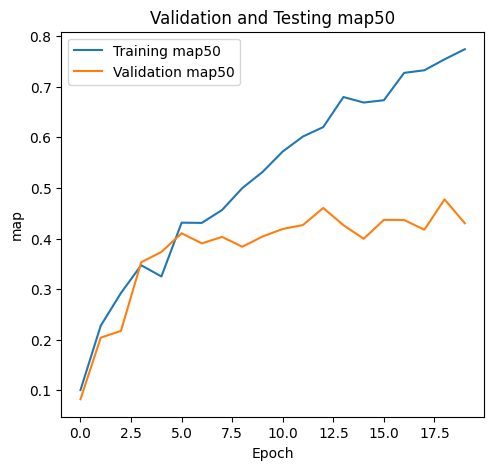

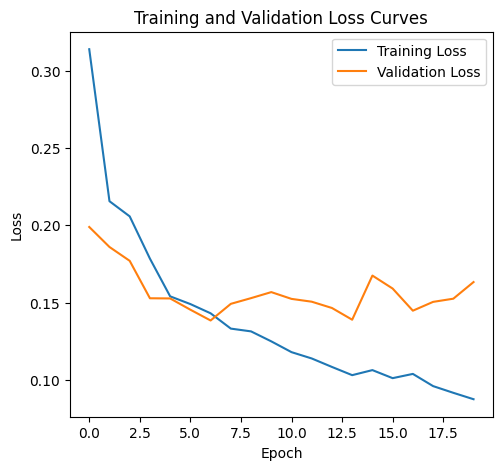

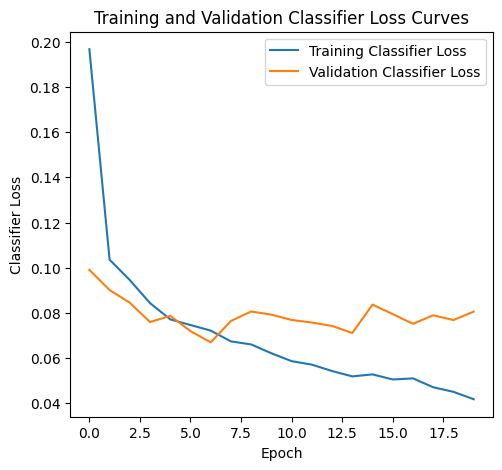

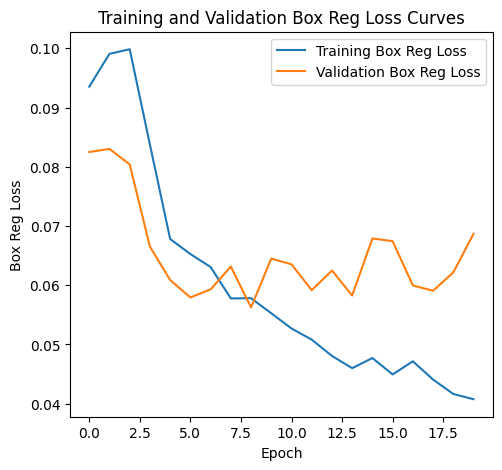

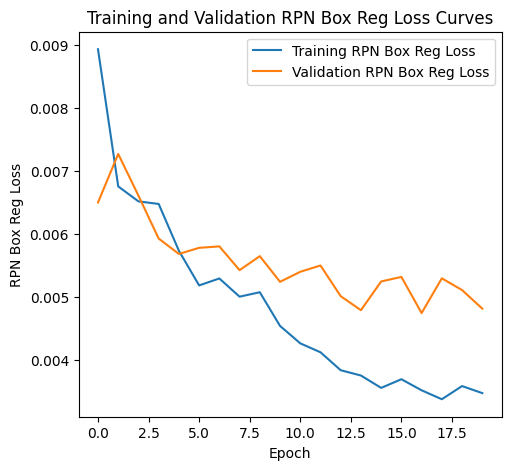

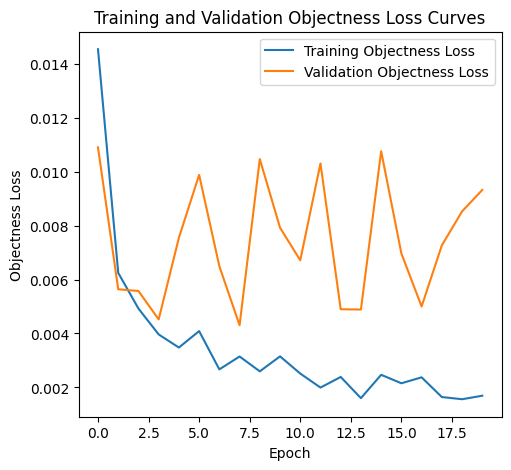

In [56]:
## IMAGENET 3
if __name__ == "__main__":
    main()

In [59]:
import os
import pandas as pd
import torch
from torchvision.transforms import functional as F
from tqdm.notebook import tqdm
from PIL import Image

# 定義測試數據集類
class TestDataset:
    def __init__(self, root, info_root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.test_info = pd.read_csv(os.path.join(info_root, "test.csv"))

    def __len__(self):
        return len(self.test_info)

    def __getitem__(self, idx):
        # 使用 Filename 來定位文件
        file_name = self.test_info.iloc[idx]["Filename"]
        img_path = os.path.join(self.root, "image", file_name.replace(".dcm", ".jpg"))  # 確保對應到 .jpg
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
        image = Image.open(img_path).convert("RGB")
        width = self.test_info.iloc[idx]["Width"]
        height = self.test_info.iloc[idx]["Height"]
        if self.transforms:
            image = self.transforms(image)
        return self.test_info.iloc[idx]["ID"], image, width, height

# 測試推論函數
def inference_on_test_set(model, test_loader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for img_ids, images, widths, heights in tqdm(test_loader):
            images = [img.to(device) for img in images]
            outputs = model(images)
            for img_id, output, img, w, h in zip(img_ids, outputs, images, widths, heights):
                w, h = float(w), float(h)  # 將寬度和高度轉為浮點數
                for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
                    if score < 0.5:  # 過濾低置信度框
                        continue
                    # 邊界框歸一化處理
                    xmin, ymin, xmax, ymax = box.tolist()
                    xmin, xmax = xmin / w, xmax / w
                    ymin, ymax = ymin / h, ymax / h
                    category = config2.categories[label.item() - 1]  # 從類別索引轉換為名稱
                    results.append({
                        "ID": img_id,
                        "category": category,
                        "score": score.item(),
                        "xmin": xmin,
                        "xmax": xmax,
                        "ymin": ymin,
                        "ymax": ymax
                    })
    return results

# 保存結果到 CSV
def save_results_to_csv(results, output_path):
    df = pd.DataFrame(results)
    df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")
    return df

# 主函數
def main():
    # 設置模型設備
    device = config2.device

    # 初始化模型
    model = fasterrcnn(num_classes=config2.num_classes)
    model.load_state_dict(torch.load(os.path.join(config2.save_root, "final.pth"))["model"])
    model.to(device)

    # 初始化測試數據集
    test_dataset = TestDataset(
        root=config2.test_root, 
        info_root=config2.info_root_test,
        transforms=F.to_tensor
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  # 一次處理一張影像
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))
    )

    # 進行推論
    print("Running inference on test set...")
    results = inference_on_test_set(model, test_loader, device)

    # 保存結果
    df = save_results_to_csv(results, os.path.join(config2.save_root, "submission.csv"))
    return df

if __name__ == "__main__":
    # 在 config2 中定義類別名稱
    class config2:
        test_root = "/kaggle/working/test"
        info_root_test = "/kaggle/input/hwk05-data/hwk05_data/test"
        save_root = "/kaggle/working"
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        num_classes = 8
        categories = [
            "aortic_curvature",
            "aortic_atherosclerosis_calcification",
            "cardiac_hypertrophy",
            "intercostal_pleural_thickening",
            "lung_field_infiltration",
            "degenerative_joint_disease_of_the_thoracic",
            "scoliosis",
            "normal"
        ]
    pred_df=main()


Running inference on test set...


  0%|          | 0/113 [00:00<?, ?it/s]

Results saved to /kaggle/working/submission.csv


In [60]:
# 顯示前10行、後10行和數據形狀
print("First 10 rows:")
print(pred_df.head(10))
print("\nLast 10 rows:")
print(pred_df.tail(10))
print("\nDataframe shape:")
print(pred_df.shape)


First 10 rows:
                      ID                                    category  \
0  TDR02_20161123_145314        aortic_atherosclerosis_calcification   
1  TDR02_20161123_145314                            aortic_curvature   
2  TDR02_20161123_145314                     lung_field_infiltration   
3  TDR02_20161123_145314  degenerative_joint_disease_of_the_thoracic   
4  TDR01_20171106_111727  degenerative_joint_disease_of_the_thoracic   
5  TDR01_20171106_111727                     lung_field_infiltration   
6  TDR01_20171106_111727                            aortic_curvature   
7  TDR01_20171106_111727                                   scoliosis   
8  TDR01_20180510_090210  degenerative_joint_disease_of_the_thoracic   
9  TDR01_20180511_092549                                   scoliosis   

      score      xmin      xmax      ymin      ymax  
0  0.961782  0.501516  0.664308  0.200134  0.381468  
1  0.787029  0.374931  0.675504  0.232649  0.719997  
2  0.758716  0.063560  0.95929

# 5-2

In [61]:
# import libraries

# basic
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd

# visualization
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
!pip install grad-cam
import pytorch_grad_cam
from pytorch_grad_cam import EigenCAM, AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image

# PyTorch
import torch
import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=666f98426457c54f6518315f1acf3e1bf652653fc49f931a0dab41fd1f26a479
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [62]:
class config3:
    
    root = "/kaggle/working/train"
    num_classes = 8
    categories = ['normal', 'aortic_curvature', 'aortic_atherosclerosis_calcification', 
                  'cardiac_hypertrophy', 'intercostal_pleural_thickening', 'lung_field_infiltration', 
                  'degenerative_joint_disease_of_the_thoracic_spine', 'scoliosis']
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config3.seed)

In [64]:
def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [config3.categories[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices,scores = [], [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
            scores.append(pred_scores[index])
    boxes = np.int32(boxes)
    
    return boxes, classes, labels, indices, scores

COLORS = np.random.uniform(0, 255, size=(len(config3.categories), 3))

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        # Convert RGB to BGR for OpenCV
        color = COLORS[labels[i]].astype(int)[::-1]
        
        # Draw the bounding box
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color.tolist(), 8
        )
        
        # Increase font size and thickness for label
        font_scale = 4 # Increase this value for larger font
        thickness = 10     # Increase thickness for better visibility
        
        # Add class label as text
        cv2.putText(image, classes[i], 
                    (int(box[0]), int(box[1]) - 10),  # Adjust text position
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    font_scale, 
                    color.tolist(), 
                    thickness,
                    lineType=cv2.LINE_AA)
    return image


In [65]:
def get_transform():
    
    transform = v2.Compose(
                [
                    v2.ToImage(), ## Used while using PIL image
                    #v2.ConvertBoundingBoxFormat(tv_tensors.BoundingBoxFormat.XYXY),
                    v2.ToDtype(torch.float32, scale=True),
                    
                ])       
    
    return transform

In [66]:
def plot_eigen_cam_images(transforms, model, cat, threshold):
    rows, cols = 4, 2
    fig = plt.figure(figsize=(10, 20))  # Adjust figure size
    grid = plt.GridSpec(rows, cols)
    
    best_ckpt = torch.load("/kaggle/working/final.pth", map_location=config3.device)
    model.load_state_dict(best_ckpt["model"])
    model.eval().to(config3.device)
    target_layers = [model.backbone]
    
    cam = EigenCAM(model, 
                   target_layers, 
                   reshape_transform=fasterrcnn_reshape_transform)
    
    for i in range(rows * cols):
        all_images = os.listdir(os.path.join(config3.root, config3.categories[i]))        
        image_path = os.path.join(config3.root, config3.categories[i], all_images[0])
        image = Image.open(image_path).convert("RGB")   
        input_tensor = transforms(image)
        input_tensor = input_tensor.to(config3.device)
        input_tensor = input_tensor.unsqueeze(0)
        image = np.array(image)
        image_float_np = np.float32(image) / 255
        boxes, classes, labels, indices, scores = predict(input_tensor, model, config3.device, threshold)        
        image = draw_boxes(boxes, labels, classes, image)
        targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
        
        grayscale_cam = cam(input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
        image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
        
        categories = fig.add_subplot(grid[i])
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(image_with_bounding_boxes)
        ax.set_title(f"{config3.categories[i]}")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("EigenCAM Images of 8 categories\n", fontweight='bold', size=16)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0.4)  # Add extra space between plots


In [67]:
def plot_ablation_cam_images(transforms, model):
    
    rows, cols = 4, 2
    fig = plt.figure(figsize = (10, 20))
    grid = plt.GridSpec(rows, cols)
    
    best_ckpt = torch.load("/kaggle/working/final.pth", map_location = config3.device)
    model.load_state_dict(best_ckpt["model"])
    model.eval().to(config3.device)
    target_layers = [model.backbone]
    
    cam = AblationCAM(model,
                      target_layers,
                      reshape_transform = fasterrcnn_reshape_transform,
                      ablation_layer = AblationLayerFasterRCNN(),
                      ratio_channels_to_ablate = 1.0)
    
    for i in range(rows * cols):
        
        all_images = os.listdir(os.path.join(config3.root, config3.categories[i]))
        image_path = os.path.join(config3.root, config3.categories[i], all_images[0])
        image = Image.open(image_path).convert("RGB")       
        input_tensor = transforms(image)
        input_tensor = input_tensor.to(config3.device)
        input_tensor = input_tensor.unsqueeze(0)
        image = np.array(image)
        image_float_np = np.float32(image) / 255

        boxes, classes, labels, indices, scores = predict(input_tensor, model, config3.device, 0)
        image = draw_boxes(boxes, labels, classes, image)
        targets = [FasterRCNNBoxScoreTarget(labels = labels, bounding_boxes = boxes)]
        
        grayscale_cam = cam(input_tensor, targets = targets)
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb = True)
        image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
        
        categories = fig.add_subplot(grid[i])
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(image_with_bounding_boxes)
        ax.set_title(f"{config3.categories[i]}")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("AblationCAM Images of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()

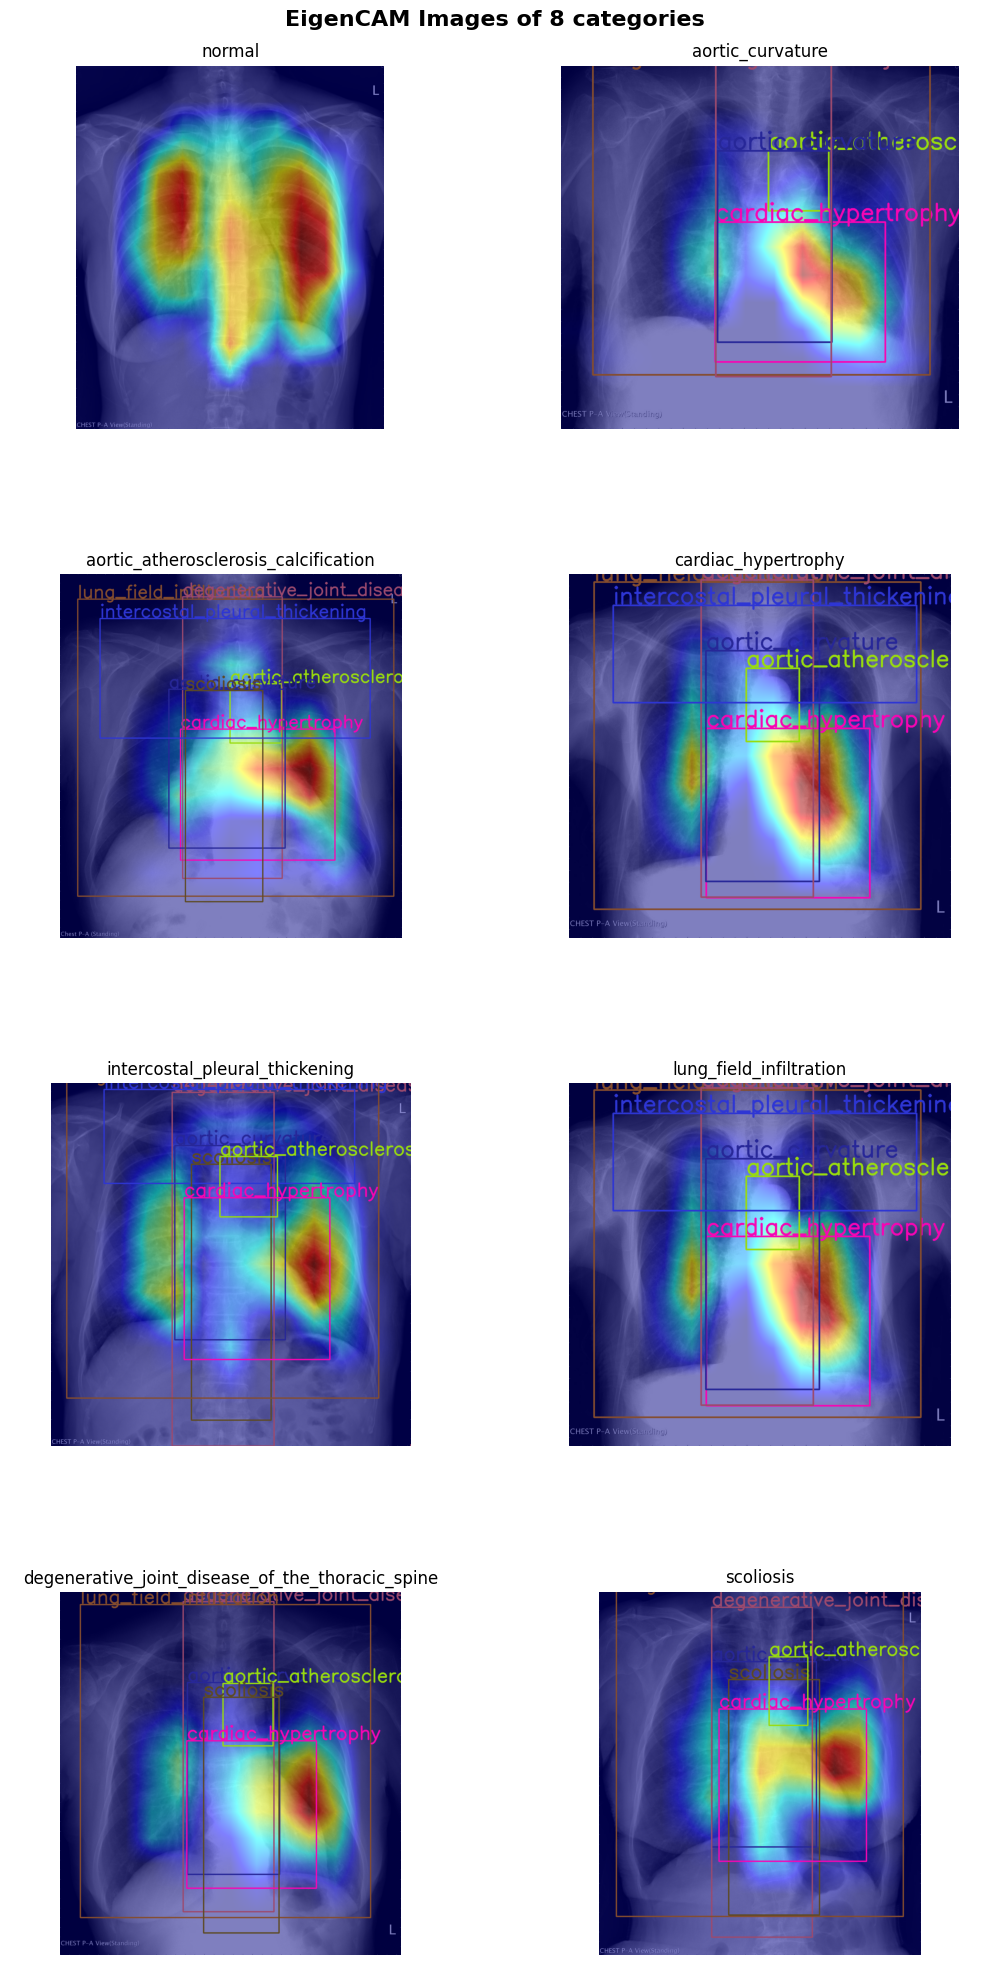

In [68]:
result = plot_eigen_cam_images(transforms = get_transform(), model = fasterrcnn(config3.num_classes), cat=0, threshold=0)

100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


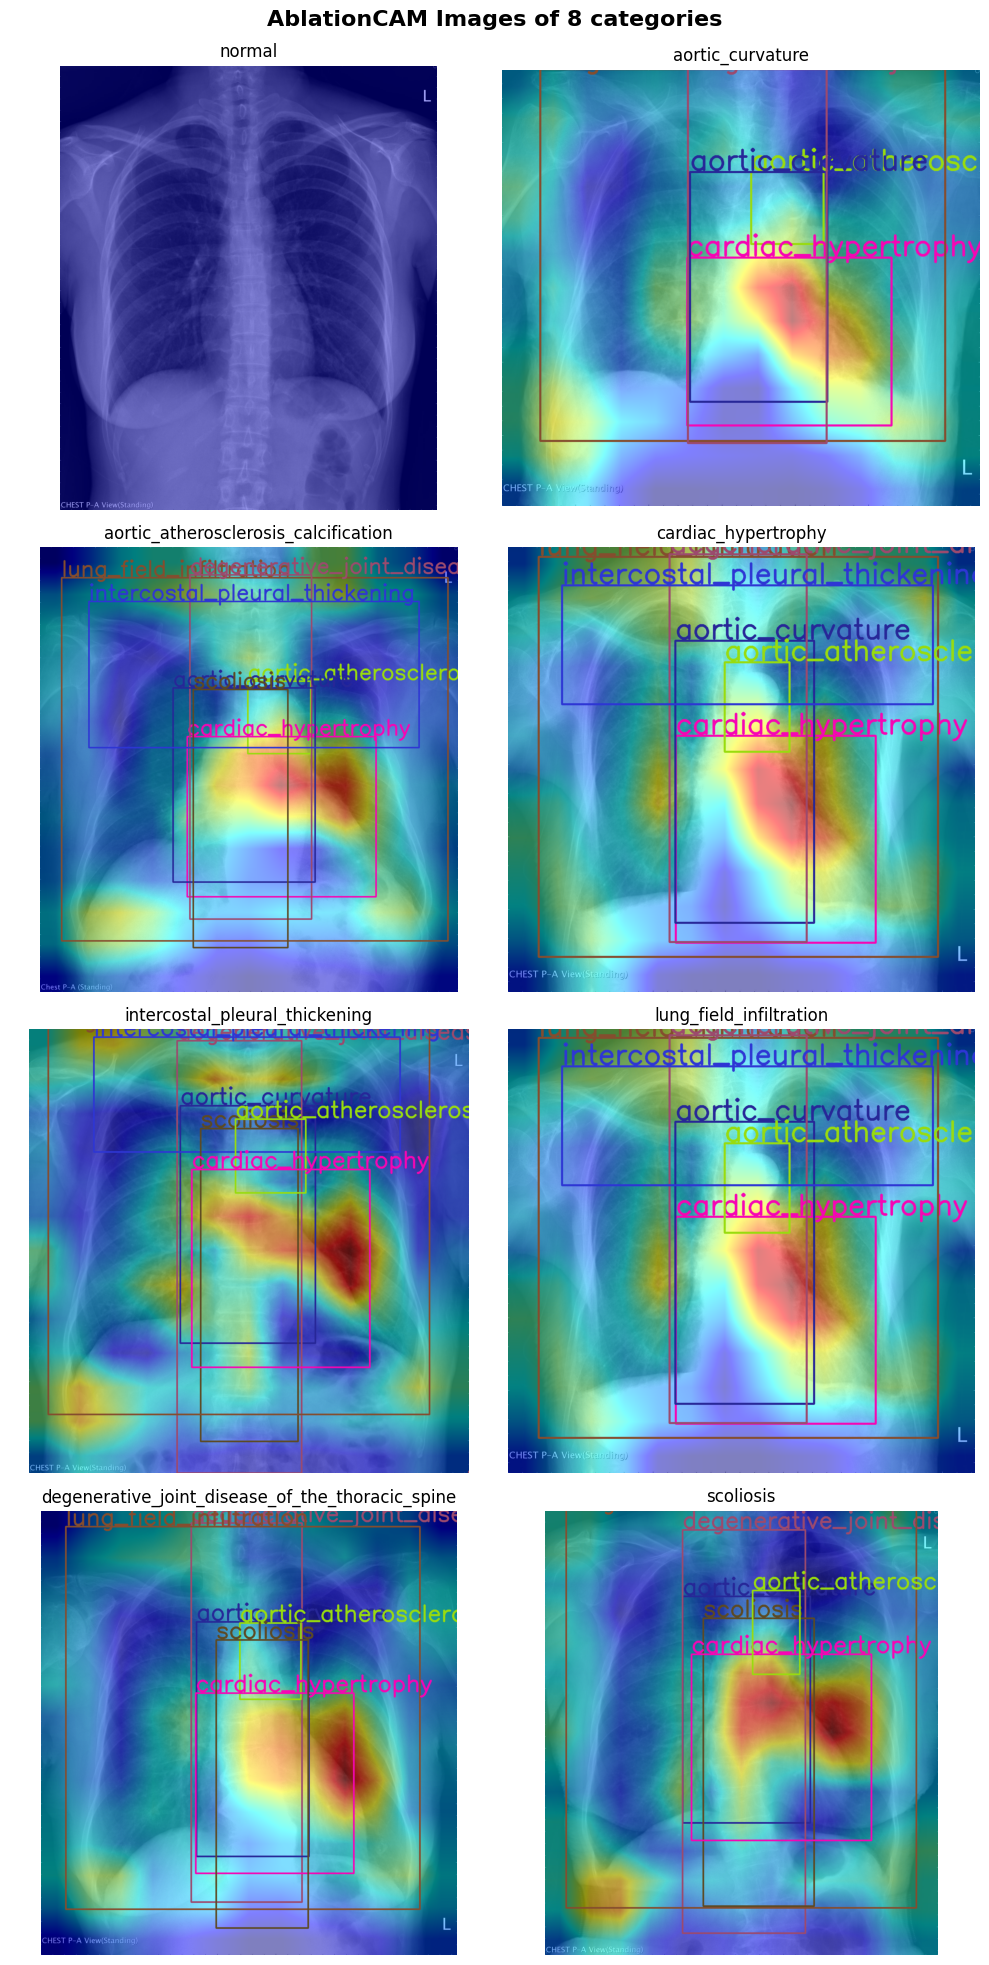

In [69]:
plot_ablation_cam_images(transforms = get_transform(), model = fasterrcnn(config3.num_classes))

In [70]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/final.pth (deflated 7%)
  adding: kaggle/working/coco_utils.py (deflated 71%)
  adding: kaggle/working/train.json (deflated 83%)
  adding: kaggle/working/engine.py (deflated 66%)
  adding: kaggle/working/transforms.py (deflated 76%)
  adding: kaggle/working/__pycache__/ (stored 0%)
  adding: kaggle/working/__pycache__/engine.cpython-310.pyc (deflated 44%)
  adding: kaggle/working/__pycache__/transforms.cpython-310.pyc (deflated 54%)
  adding: kaggle/working/__pycache__/coco_eval.cpython-310.pyc (deflated 51%)
  adding: kaggle/working/__pycache__/coco_utils.cpython-310.pyc (deflated 53%)
  adding: kaggle/working/__pycache__/utils.cpython-310.pyc (deflated 50%)
  adding: kaggle/working/train/ (stored 0%)
  adding: kaggle/working/train/aortic_curvature/ (stored 0%)
  adding: kaggle/working/train/aortic_curvature/FILE0.jpg (deflated 7%)
  adding: kaggle/working/train/aortic_curvature/220_5.jpg (deflated 7%)
  adding: kaggle/wor